# Anomaly Record Detection in Sequence Data using Support Vector Machines -  Yahoo Data A3 and A4 benchmarks (Univariate)

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import import_ipynb
from Deviation_Threshold import get_deviations, get_anomaly_labels_by_deviation_threshold, get_anomaly_labels_by_deviation_pctile_threshold
import glob
from sklearn.metrics import precision_recall_fscore_support
import warnings
import statistics
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from functools import reduce
from sklearn.model_selection import GridSearchCV
import pickle

warnings.filterwarnings('ignore')

%matplotlib inline


importing Jupyter notebook from Deviation_Threshold.ipynb


In [3]:
def generate_dataframe_with_sliding_window(sliding_window, df, anomaly_col_name):
    """
    Generates a feature set with the given sliding window size. The feature set does not contain the anomaly_col_name
    
    sliding_window - an int, specifies how many previous time series should be considered as input for the
                     current time series

    df - cleaned time series dataframe which contains the anomaly column and only other relevant fields that need to 
         be considered, when generating the feature dataframe
         
    anomaly_col_name - name of the anomaly column
    
    return a merged dataframe which includes previous time series that should be considered as input for the
                     current time series
    
    """
    dataframes = []
    original_df = df.copy(deep=True)
    original_df = original_df.drop([anomaly_col_name], axis=1)
    for i in range(1,sliding_window+1):
        copied = original_df
        
        for j in range(1, i+1):
            copied = copied.append(pd.Series(), ignore_index=True)
        copied = copied.shift(i)
        dataframes.append(copied)
    
    df_merged = reduce(lambda left,right: right.merge(left,left_index=True,right_index=True), dataframes)
    return df_merged

In [4]:
def createColumnDict(columnNames):
    """
    Generates a dictionary which contains a mapping between column names to the target column names
    
    columnNames - current names of the columns
    
    return a dictionary which contains a mapping between column names
            Ex: ["timestamp", "value", "is_anomaly"]
            {"timestamp": "timestamp_y", "value": "value_y", "is_anomaly": "is_anomaly_y"}
    """
    
    dict = {}
    for name in columnNames:
        dict[name] = name + "_current"
    
    return dict

def get_classification_metrics(actual, predicted):
    
    return confusion_matrix(actual, predicted), precision_score(actual, predicted), \
    recall_score(actual, predicted), f1_score(actual, predicted)

In [5]:
def fit_train_eval_model(X_train, Y_train, X_test, Y_test, outlier_df, pctile, sliding_window):
    
    # When using without pipeline, put estimator__ before parameters
    param_grid = {'epsilon':[0.2, 0.3, 0.4, 0.5],
                  'C':[1, 25, 50],
                  'gamma':['scale', 'auto']}

    svm_clf = SVR(kernel='rbf')
    gs = GridSearchCV(svm_clf, param_grid=param_grid, cv=2, scoring = 'neg_mean_squared_error', n_jobs=-1)
    gs.fit(X_train,np.ravel(Y_train))
    
    best_est = gs.best_estimator_
    best_params = gs.best_params_
    
    Y_predict = best_est.predict(X_test)
    
    predictedAnomalyLabels = get_anomaly_labels_by_deviation_pctile_threshold(np.ravel(Y_test), np.ravel(Y_predict), pctile) 

    # Compare calculated labels and actual labels to find confusion matrix, precision, recall, and F1
    conf_matrix, prec, recall, f1 = get_classification_metrics(np.ravel(outlier_df), predictedAnomalyLabels)

    return best_params, conf_matrix, prec, recall, f1
    

In [6]:
def predictTimeSeries(file_path, anomaly_col_name, sliding_window=1, percentile=75.0, epsilon=0.1, gamma='scale', C=1.0):
    """
    This function reads in csv's in the given path and processes each of them, based on the sliding window.
    Creates a Support Vector Regression Model and fits 80% of the data and predicts 20% of the data
    
    file_path - path to the csv files
    sliding_window - how many previous entries should be considered as inputs to the current entry
    
    return - dictionary of dictionaries for each csv file. The inner dictionary contains best_params, confusion_matrix,
             precision, recall and F1-score for each sling_window value
             Ex: {key,value} --> {fileName, { sliding_window : [best_params, confusion_matrix, precision, recall, f1-score]}
    """
    
    full_results = {}
    
    a1_csv = glob.glob(file_path, recursive=True)
    for index,file in enumerate(a1_csv):

        # Read in 1 csv file
        df_original = pd.read_csv(file)
        fname = file.split("/")[4].replace('\\','').split(".")[0]
        #print(fname, "\n")

        if(not(fname == 'A3Benchmark_all' or fname == 'A4Benchmark_all')):
        
            results_dict = {}

            # train and predict for each file
            for k in range(1, sliding_window+1):

                # these csv files have 9 attributes, but we need only 'value' and 'anomaly'
                df_original = df_original[['value','anomaly']]
                df = df_original.copy(deep=True)

                merged_new = generate_dataframe_with_sliding_window(k, df, anomaly_col_name)

                df = df.append(pd.Series(), ignore_index=True)
                columnNames = df.columns
                df = df.rename(columns=createColumnDict(columnNames))
                merged_final = merged_new.merge(df, left_index=True, right_index=True)

                # drop rows which have NaN values. There will be k number of rows at the top with NaN values
                indexes_to_drop = []
                for i in range(0, k):
                    indexes_to_drop.append(i)

                # last row will also have a NaN value
                last_index = merged_new.shape[0] - 1
                indexes_to_drop.append(last_index)
                merged_final = merged_final.drop(indexes_to_drop)

                # anomaly column name was also modified previously, hence the new name
                modified_anomaly_col_name = anomaly_col_name + "_current"

                Y_columns = list(df.columns)
                Y_columns.remove(modified_anomaly_col_name)
                X_columns = merged_new.columns

                # split the dataset into training and testing
                train_size = int(len(merged_final) * 0.8)
                train_set, test_set = merged_final[:train_size],merged_final[train_size:]

                #seperate into features and target
                X_train = train_set[X_columns]
                Y_train = train_set[Y_columns]
                X_test = test_set[X_columns]
                Y_test = test_set[Y_columns]

                # outlier_y column is not needed for forecasting, but needed later to detect outliers
                outlier_df = test_set[[modified_anomaly_col_name]]

                results = fit_train_eval_model(X_train, Y_train, X_test, Y_test, outlier_df, percentile, k)

                # save the results in a dictionary
                results_dict[k] = results

            
            full_results[fname] = results_dict

    return full_results


In [4]:
def draw_box_plots_new(p1, r1, f1):

    """
    Takes in 3 lists (precision results, recall results, f1-score results) and plots
    3 boxplots, each having 1 box plot
    """

    fig, ax = plt.subplots(1,3, figsize=(10, 7))
    fig.subplots_adjust(hspace=0.4, wspace=0.7)

    ax[0].set_title('Precision')
    ax[0].boxplot(p1)

    ax[1].set_title('Recall')
    ax[1].boxplot(r1)

    ax[2].set_title('F1-score')
    ax[2].boxplot(f1)

    plt.show()
    
def generate_median_table_new(p1, r1, f1):
    """
    Generates a table which includes the median of precision, recall and f1-score results
    
    """
    
    l1 = [['precision', statistics.median(p1)],
          ['recall', statistics.median(r1)],
          ['f1-score', statistics.median(f1)]]
    table1 = tabulate(l1, headers=['', 'Median' ], tablefmt='orgtbl')
    print()
    print(table1)


def get_result_lists(best_result_dict):
    precisions = []
    recalls = []
    f1s = []

    all_f1_scores = {}
    for fname in best_result_dict:
        #print(fname)
        dict_per_file = best_result_dict[fname]

        f1_scores_of_file = []
        for sliding_window in dict_per_file:
            result = dict_per_file[sliding_window]

            if sliding_window == 24:
                precisions.append(result[2])
                recalls.append(result[3])
                f1s.append(result[4])

            f1_scores_of_file.append(result[4])

        all_f1_scores[fname] = f1_scores_of_file

    return precisions, recalls, f1s, all_f1_scores


def draw_plots(dictionary):
    
    precisions, recalls, f1s, all_f1_scores = get_result_lists(dictionary)
    
    avg_prec = np.average(np.array(precisions))
    avg_recall = np.average(np.array(recalls))
    avg_f1 = np.average(np.array(f1s))

    min_prec = min(np.array(precisions))
    min_recall = min(np.array(recalls))
    min_f1 = min(np.array(f1s))

    max_prec = max(np.array(precisions))
    max_recall = max(np.array(recalls))
    max_f1 = max(np.array(f1s))    

    print(" Avg precision {0:.5f} recall {1:.5f} f1 {2:.5f} for a sliding window of 24".format(avg_prec, avg_recall, avg_f1))
    print(" Min precision {0:.5f} recall {1:.5f} f1 {2:.5f} for a sliding window of 24".format(min_prec, min_recall, min_f1))
    print(" Max precision {0:.5f} recall {1:.5f} f1 {2:.5f} for a sliding window of 24".format(max_prec, max_recall, max_f1))

    #draw Precision, Recall, F1-score for each file when sliding window=24
    plt.figure(figsize=(40,10))
    plt.xlabel('file')
    plt.title('Precision, Recall, F1-score for each file when sliding window=24')
    plt.plot(precisions, label ='Precisions')
    plt.plot(recalls, label ='Recall')
    plt.plot(f1s, label ='F1s')
    plt.legend(("Precisions", 'Recall', "F1"), loc=1)
    plt.show() 
    
    # draw F1-score vs sliding window
    fig=plt.figure(figsize=(20,10))
    ax=fig.add_axes([0,0,1,1])
    sliding_windows = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

    for fname in all_f1_scores:
        f1s = all_f1_scores[fname]
        ax.plot(sliding_windows, f1s, label = fname)

    ax.legend()
    ax.set_xlabel('Sliding window size')
    ax.set_ylabel('F1-score')
    ax.set_title('F1-score vs sliding window size')
    plt.show()

### A3 Benchmark

In [14]:
A3_all_best_results = predictTimeSeries('./data/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark_processed/*.csv','anomaly', sliding_window=24, percentile=99.5)
f = open("univariate_results/A3_best.pkl","wb")
pickle.dump(A3_all_best_results,f)
f.close()

 Avg precision 0.52000 recall 0.47533 f1 0.46314 for a sliding window of 24
 Min precision 0.00000 recall 0.00000 f1 0.00000 for a sliding window of 24
 Max precision 1.00000 recall 1.00000 f1 1.00000 for a sliding window of 24


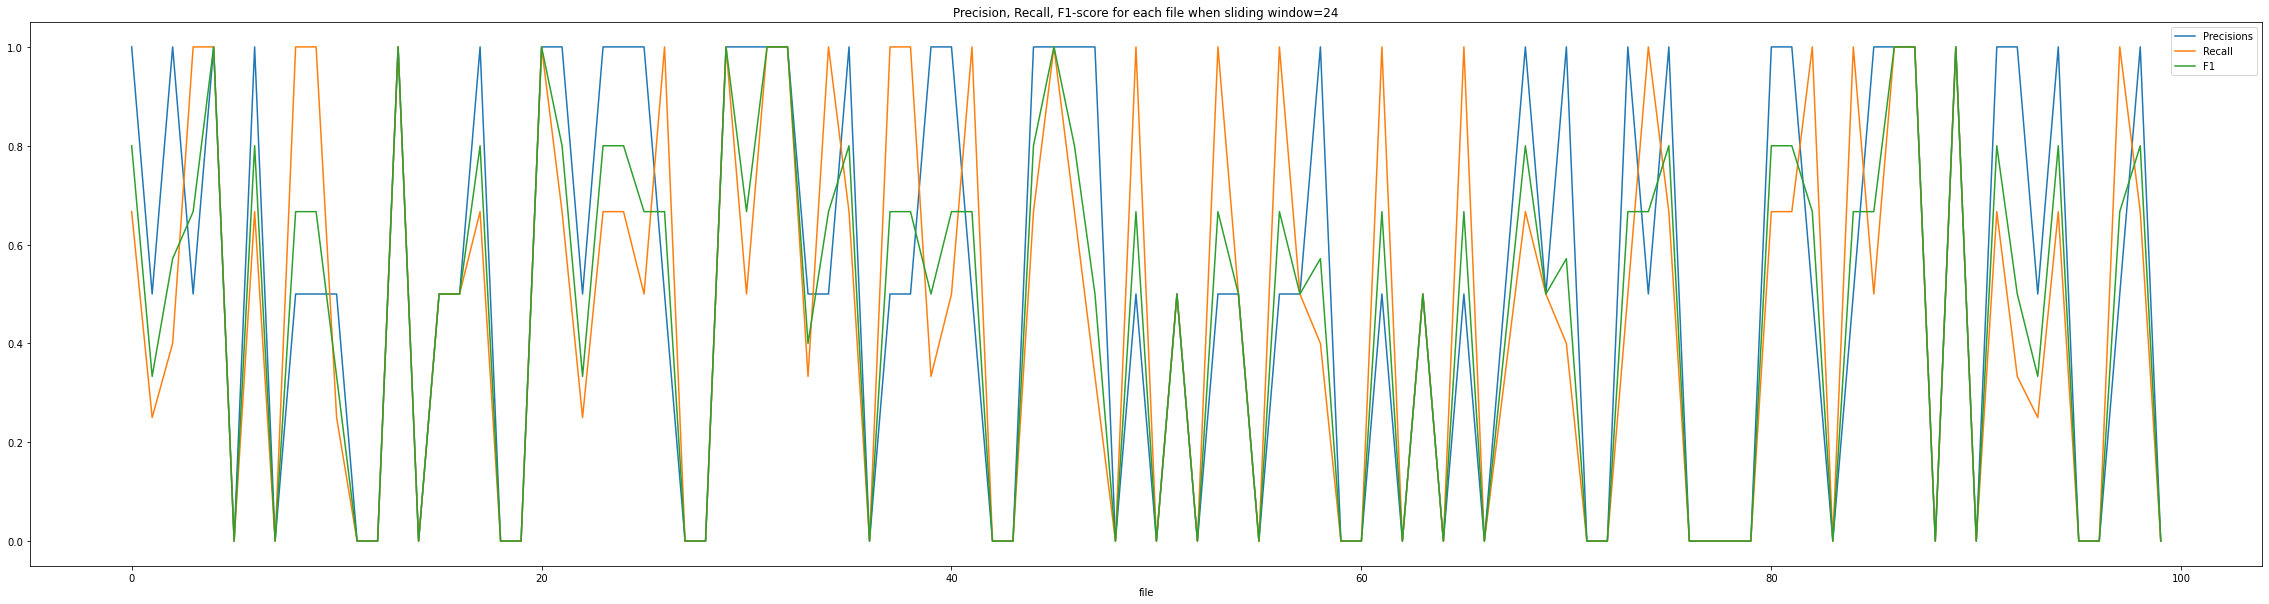

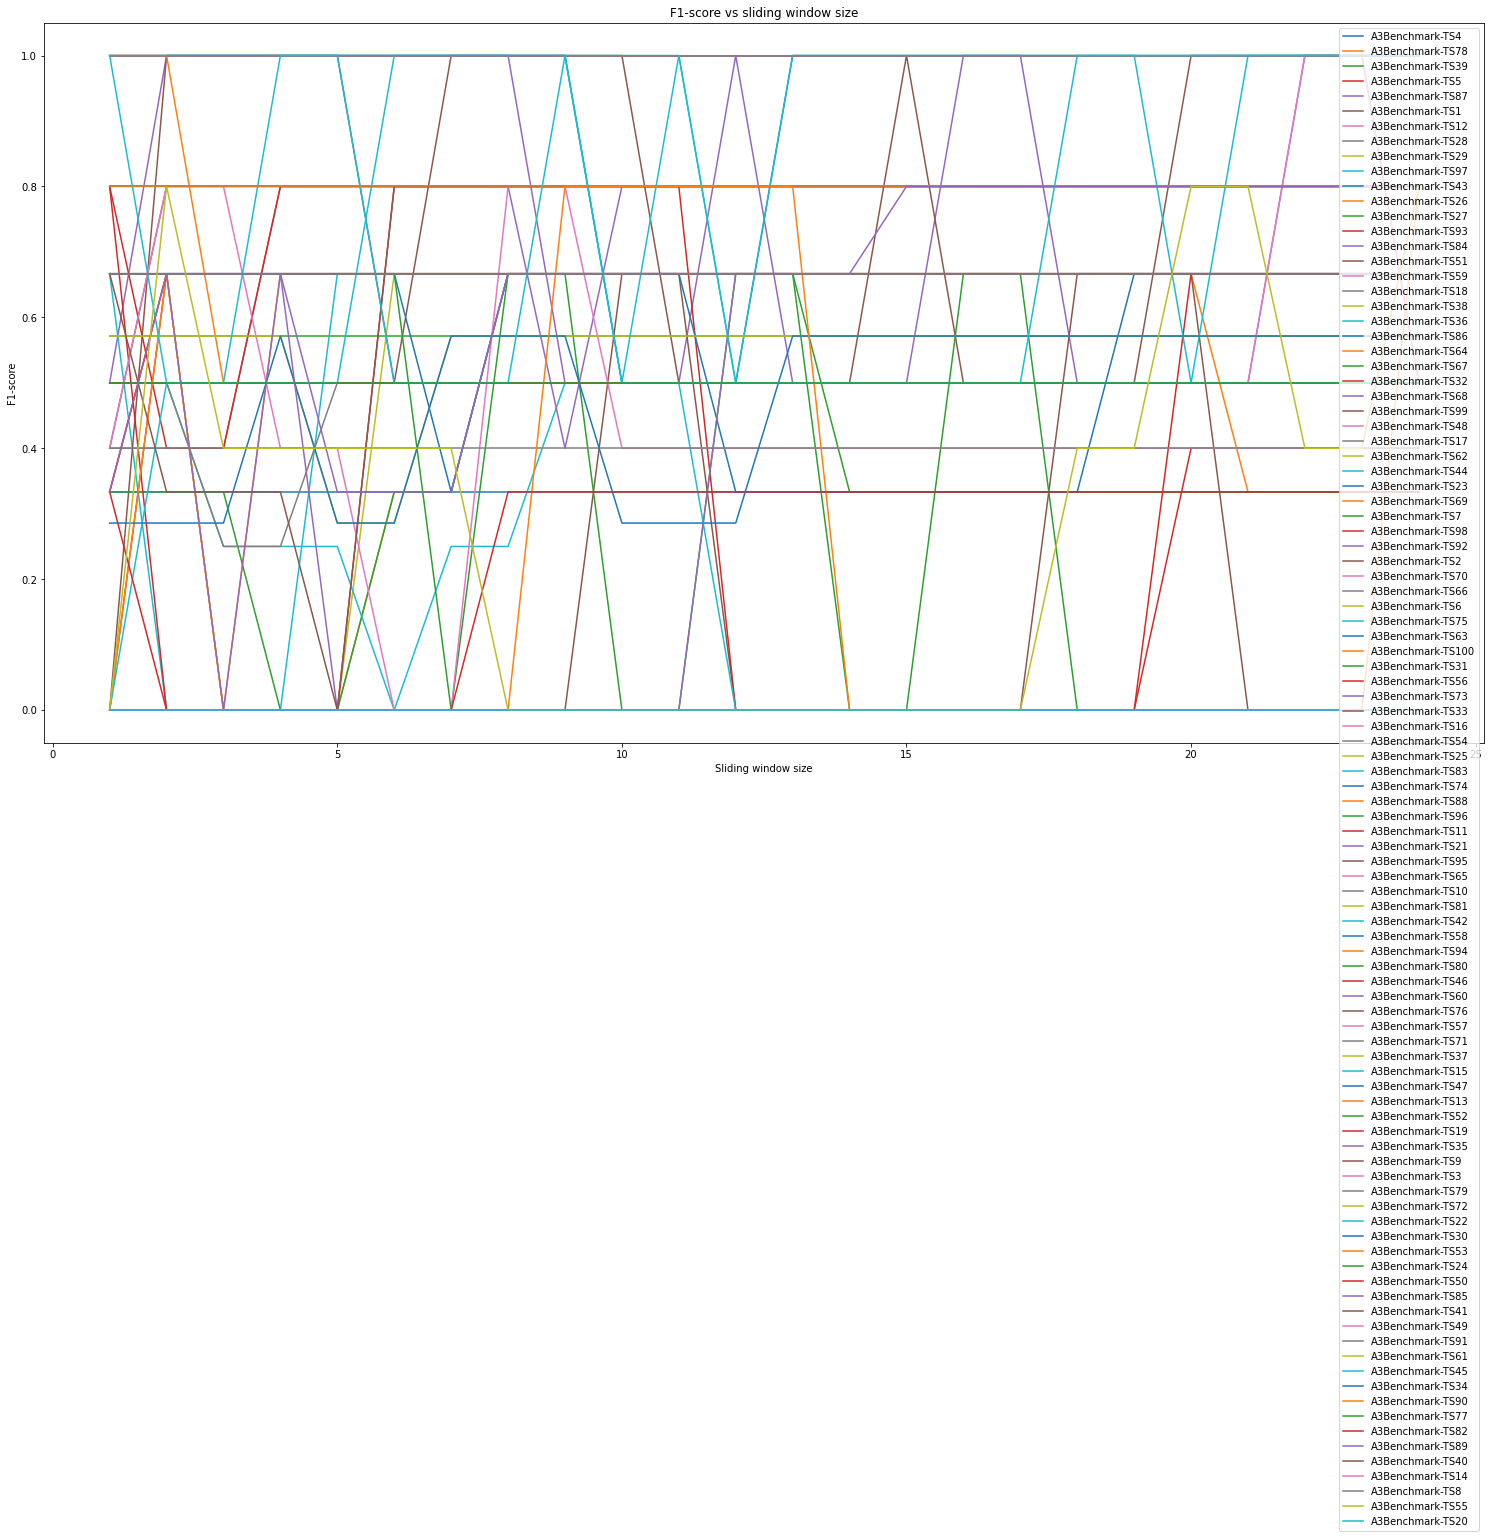

In [8]:
draw_plots(A3_all_best_results)

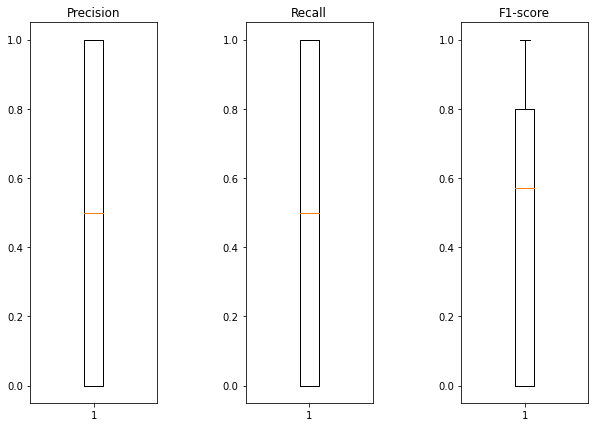


|           |   Median |
|-----------+----------|
| precision | 0.5      |
| recall    | 0.5      |
| f1-score  | 0.571429 |


In [9]:
# box plots for precision, recall and f1-score when sliding window=24
precision, recalls, fls, all_f1_scores = get_result_lists(A3_all_best_results)

draw_box_plots_new(precision, recalls, fls)
generate_median_table_new(precision, recalls, fls)

### A4 Benchmark

In [15]:
A4_all_best_results = predictTimeSeries('./data/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark_processed/*.csv','anomaly', sliding_window=24, percentile=99.5)
f = open("univariate_results/A4_best.pkl","wb")
pickle.dump(A4_all_best_results,f)
f.close()

 Avg precision 0.41500 recall 0.41000 f1 0.38795 for a sliding window of 24
 Min precision 0.00000 recall 0.00000 f1 0.00000 for a sliding window of 24
 Max precision 1.00000 recall 1.00000 f1 1.00000 for a sliding window of 24


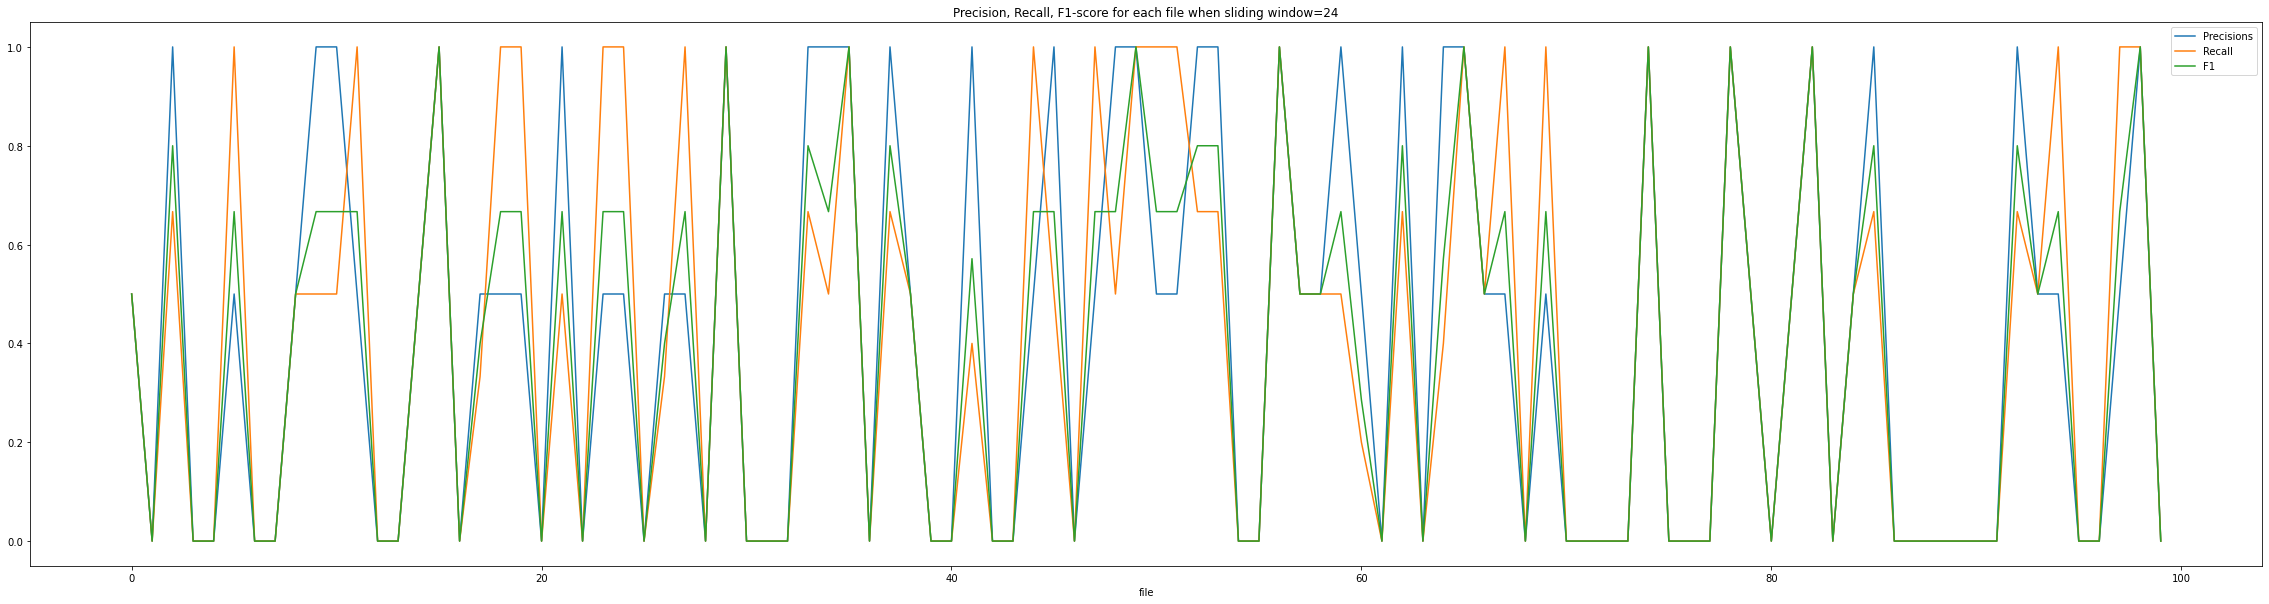

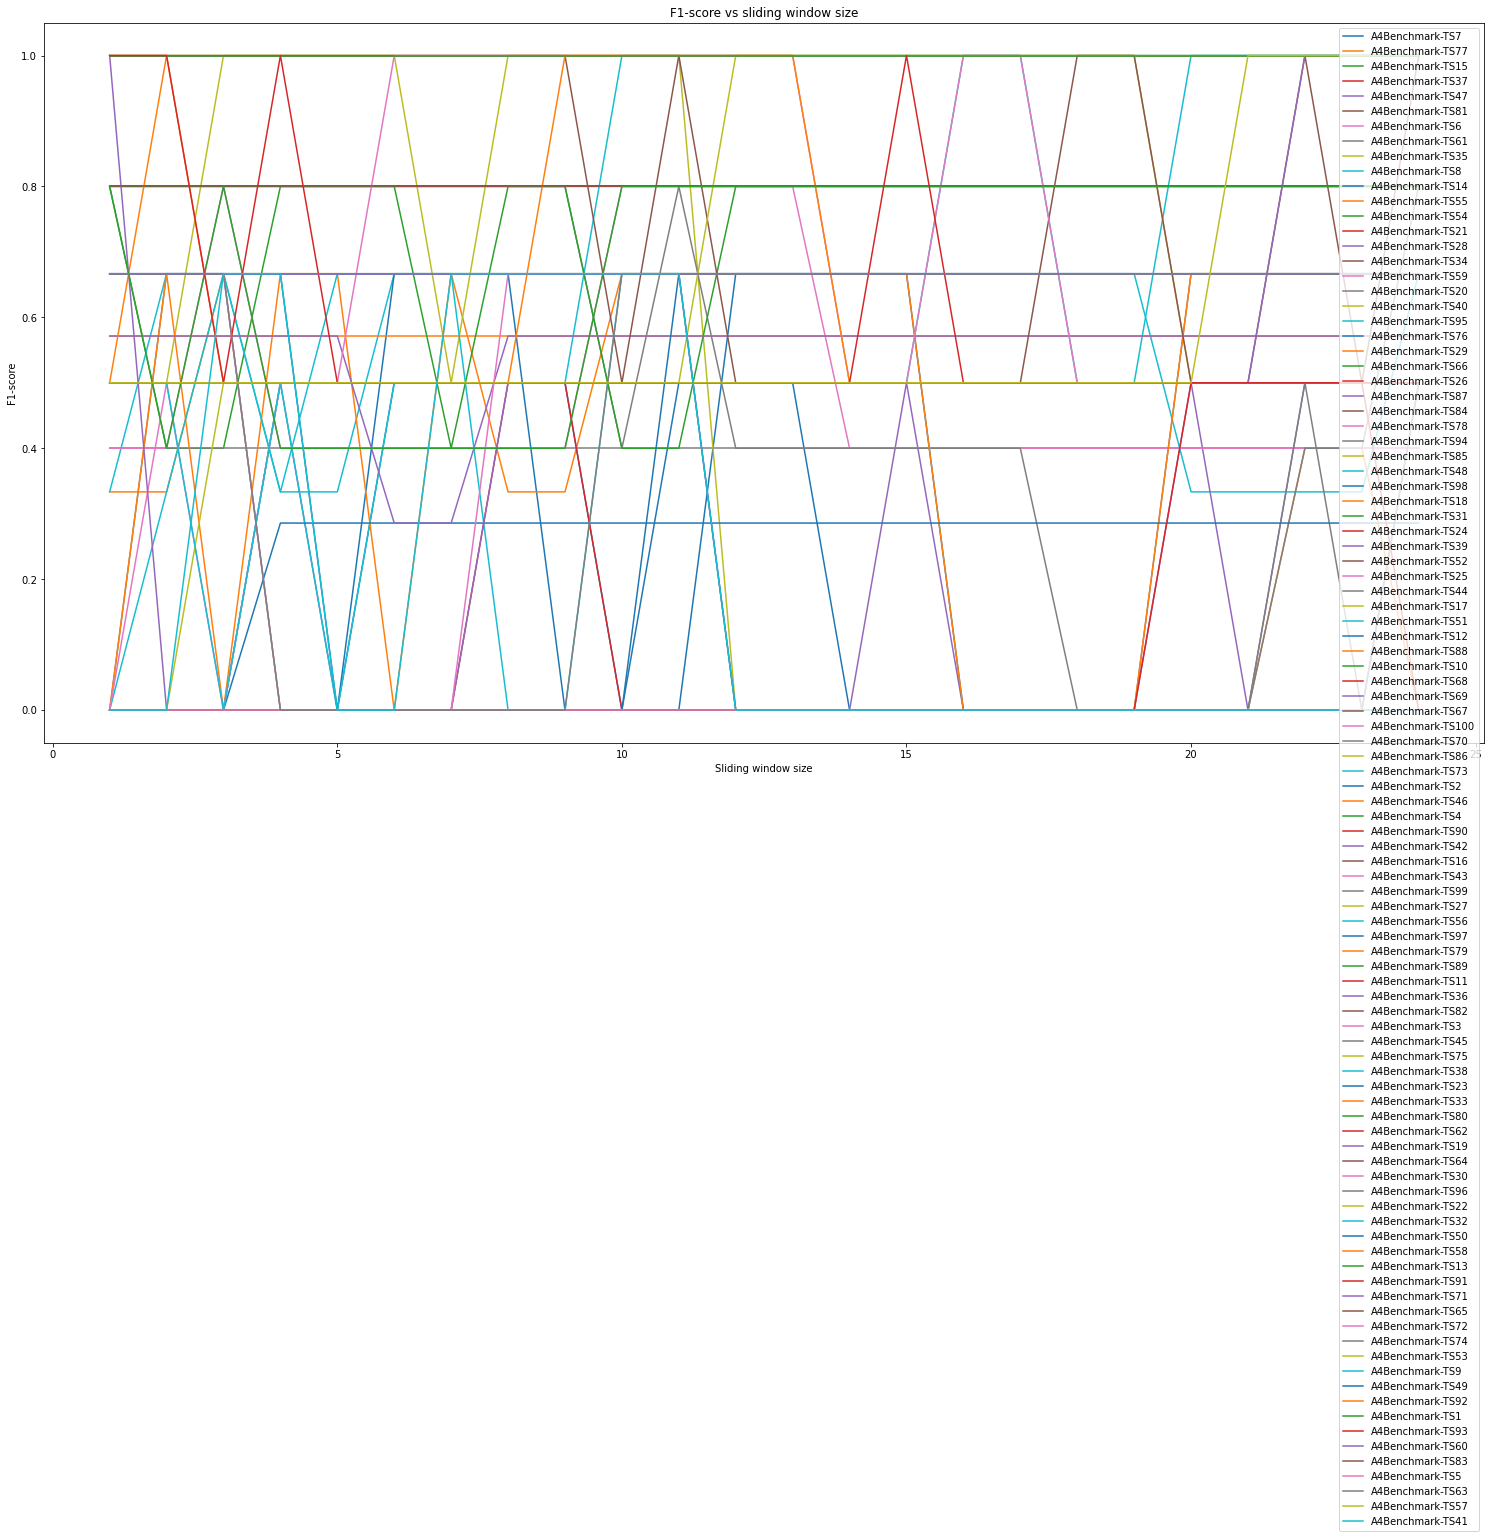

In [5]:
draw_plots(A4_all_best_results)

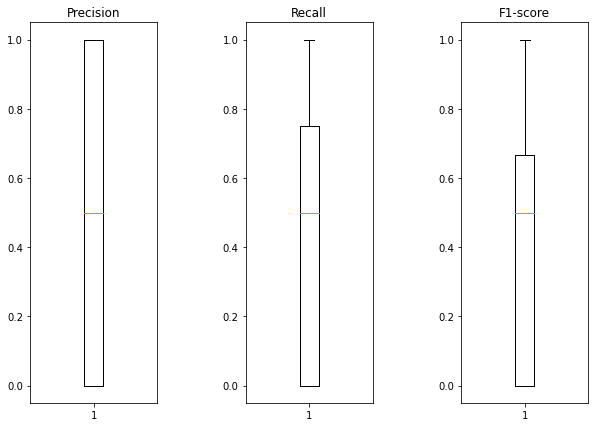


|           |   Median |
|-----------+----------|
| precision |      0.5 |
| recall    |      0.5 |
| f1-score  |      0.5 |


In [6]:
# box plots for precision, recall and f1-score when sliding window=24
precision, recalls, fls, all_f1_scores = get_result_lists(A4_all_best_results)

draw_box_plots_new(precision, recalls, fls)
generate_median_table_new(precision, recalls, fls)